Contributor: Debanjan Saha

Running on: Local Machine

In [ ]:
# Important Libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 

import re
from collections import Counter

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

import os
import random
from tqdm.notebook import tqdm

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [ ]:
# Fix seed 

global_seed = 42

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed(global_seed)

## Load Dataset

In [ ]:
df = pd.read_csv("IMDB_Dataset.csv")

## Data Analysis

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
df.isnull().any()

review       False
sentiment    False
dtype: bool

In [ ]:
df['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

## Data preprocessing (for cleaning text)

In [ ]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
import re
import contractions

In [ ]:
def clean_text(text):
    # Remove HTML Tags
    TAG_RE = re.compile(r'<[^>]+>') 
    text = TAG_RE.sub('', text.lower())
    
    ## Remove Emojis
    text=text.encode("ascii","ignore")
    text=text.decode()
    
    ## Ignore Numbers
    text=''.join(i for i in text if not i.isdigit())
    
    ## Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text) 
    
    ## Remove nltk standard stopwords
    text = ' '.join([i for i in text.split() if not i in STOPWORDS])
  
    #contractions
    text=contractions.fix(text)
    
    #lemmatizer
    text=lemmatizer.lemmatize(text)
    return text

In [ ]:
clean_text(df['review'][1])

'wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating every surface terribly well done'

In [ ]:
df['review'] = df['review'].apply(clean_text)
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter mattei love time money visually stunnin...,positive


## Apply labels

In [ ]:
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df.head()

,review,sentiment,label
0,one reviewers mentioned watching oz episode ho...,positive,1
1,wonderful little production filming technique ...,positive,1
2,thought wonderful way spend time hot summer we...,positive,1
3,basically family little boy jake thinks zombie...,negative,0
4,petter mattei love time money visually stunnin...,positive,1


## Review length analysis

In [ ]:
def plot_top_k_words(k=20):
    words = [word for text in df['review'] for word in text.split()]
    count_words = Counter(words)
    most_freq_words = count_words.most_common(k)
    wordlist = []
    freqlist = []
    for word, freq in most_freq_words:
        wordlist .append(word)
        freqlist.append(freq)
        
    plt.figure(figsize=(12, 5))
    plt.bar(wordlist, freqlist)
    plt.title(f'Top {k} most common words', size=15)
    plt.show()

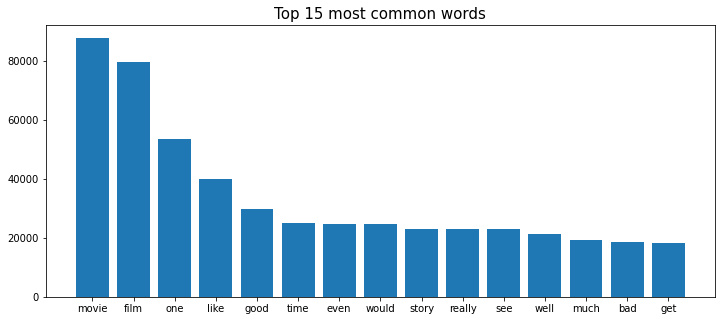

In [ ]:
plot_top_k_words(15)

## Pretrained embedding generation [My Choice: Word2Vec]

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec

In [ ]:
hyperparams = {
    "embedding_dim" : 64,
    "batch_size" : 50,
    "hidden_dim" : 256,
    "output_size" : 1,
    "n_layers" : 1,
    "lr" : 0.001,
    "clip" : 5,
    "epochs": 5,
}

In [ ]:
data = []

# empty string
data.append([''])

# iterate through each sentence in the training sentences
for sentence in df['review']:
    cur_sent = []
    # tokenize the sentence into words
    for word in sentence.split():
        cur_sent.append(word.lower())
    data.append(cur_sent)

In [ ]:
embedding_dim = hyperparams["embedding_dim"]

w2v_model = Word2Vec(data, min_count=1, vector_size=embedding_dim, window=5, workers=4)

In [ ]:
# w2v_model.wv.key_to_index['']

In [ ]:
reviews_idx = []
for text in df['review']:
    r = [w2v_model.wv.key_to_index[word] for word in text.split()]
    reviews_idx.append(r)

# print(reviews_int[:1])

In [ ]:
review_len = [len(x) for x in reviews_idx]
df['review_len'] = review_len
df.head()

,review,sentiment,label,review_len
0,one reviewers mentioned watching oz episode ho...,positive,1,163
1,wonderful little production filming technique ...,positive,1,86
2,thought wonderful way spend time hot summer we...,positive,1,84
3,basically family little boy jake thinks zombie...,negative,0,64
4,petter mattei love time money visually stunnin...,positive,1,125


count    50000.00000
mean       118.22032
std         89.40908
min          3.00000
25%         63.00000
50%         88.00000
75%        144.00000
max       1416.00000
Name: review_len, dtype: float64


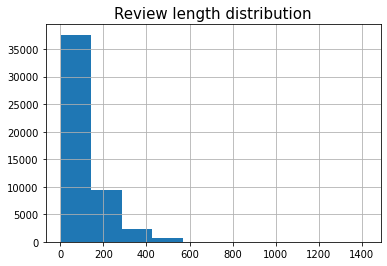

In [ ]:
print(df['review_len'].describe())
df['review_len'].hist()
plt.title('Review length distribution', size=15)
plt.show()

## Features

In [ ]:
def generate_features(review_idx, sequence_len):
    features = np.zeros((len(reviews_idx), sequence_len), dtype = int)
    
    for i, review in enumerate(reviews_idx):
        feat = None
        if len(review) >= sequence_len:
            feat = review[: sequence_len]
            
        else:
            temp = list(np.full(sequence_len - len(review), w2v_model.wv.key_to_index['']))
            feat = review + temp

        features[i, :] = np.array(feat)
            
    return features

In [ ]:
features = generate_features(reviews_idx, 128)
# print(features[0, :])

In [ ]:
print(features.shape)

(50000, 128)


In [ ]:
X_train, X_remain, y_train, y_remain = train_test_split(features, df['label'].to_numpy(), test_size=0.2, random_state=global_seed)
X_dev, X_test, y_dev, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=global_seed)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_dev.shape, y_dev.shape)
print(X_test.shape, y_test.shape)

(40000, 128) (40000,)
(5000, 128) (5000,)
(5000, 128) (5000,)


## Dataloader

In [ ]:
# dataloaders
batch_size = hyperparams["batch_size"]

# create tensor dataset
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
dev_data = TensorDataset(torch.from_numpy(X_dev), torch.from_numpy(y_dev))

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
dev_loader = DataLoader(dev_data, shuffle=True, batch_size=batch_size)

### Device

In [ ]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [ ]:
pretrained_w2v_embeddings = torch.FloatTensor(w2v_model.wv.vectors)

In [ ]:
class sentimentLSTM(nn.Module):
    """
    The Bi-LSTM model to perform Sentiment analysis.
    """
    
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()
        
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # Embedding and LSTM layers
        self.embedding = nn.Embedding.from_pretrained(pretrained_w2v_embeddings)
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            n_layers, 
            bidirectional=True,
            batch_first=True
        )
        
        self.dropout = nn.Dropout(0.3)
        
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        sig_out = self.sigmoid(out)
        
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]

        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        """
            Initializes hidden state 
        """
        
        h0 = torch.zeros((2*self.n_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((2*self.n_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

## Instantiate the model with hyperparams

In [ ]:
vocab_size = len(w2v_model.wv.key_to_index)
output_size = 1
hidden_dim = hyperparams["hidden_dim"]
n_layers = hyperparams["n_layers"]

model = sentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

In [ ]:
model = model.to(device)

In [ ]:
!mkdir -p "saved_model"

In [ ]:
lr=hyperparams["lr"]

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

## Training and validation

In [ ]:
clip = hyperparams["clip"]
epochs = hyperparams["epochs"]
valid_loss_min = np.Inf

epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0

    print(f"Running Epoch {epoch+1}/{epochs}...")

    model.train()

    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   

        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())

        accuracy = acc(output,labels)
        train_acc += accuracy

        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    epoch_train_loss = np.mean(train_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_tr_acc.append(epoch_train_acc)

    print(f'train_loss : {epoch_train_loss}')
    print(f'train_accuracy : {epoch_train_acc*100}')
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in dev_loader:
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())
            
        accuracy = acc(output,labels)
        val_acc += accuracy
            
    epoch_val_loss = np.mean(val_losses)
    epoch_val_acc = val_acc/len(dev_loader.dataset)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_vl_acc.append(epoch_val_acc)

    print(f'Dev_loss : {epoch_val_loss}')
    print(f'Dev_accuracy : {epoch_val_acc*100}')
    
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'saved_model/bilstm_model.ckpt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print('-------------------------------------------------------------------------------')

Running Epoch 1/5...
train_loss : 0.6910556026548147
train_accuracy : 52.47500000000001
Dev_loss : 0.6902347093820572
Dev_accuracy : 53.0
Validation loss decreased (inf --> 0.690235).  Saving model ...
-------------------------------------------------------------------------------
Running Epoch 2/5...
train_loss : 0.47705568104982377
train_accuracy : 77.775
Dev_loss : 0.398704165071249
Dev_accuracy : 82.76
Validation loss decreased (0.690235 --> 0.398704).  Saving model ...
-------------------------------------------------------------------------------
Running Epoch 3/5...
train_loss : 0.3854602662287652
train_accuracy : 83.23
Dev_loss : 0.35922286882996557
Dev_accuracy : 84.8
Validation loss decreased (0.398704 --> 0.359223).  Saving model ...
-------------------------------------------------------------------------------
Running Epoch 4/5...
train_loss : 0.3618914450332522
train_accuracy : 84.24000000000001
Dev_loss : 0.3421985830366612
Dev_accuracy : 85.1
Validation loss decreased (

## Testing

In [ ]:
model.load_state_dict(torch.load("saved_model/bilstm_model.ckpt"))

<All keys matched successfully>

In [ ]:
model.to(device)

In [ ]:
test_losses = [] 
num_correct = 0

test_h = model.init_hidden(batch_size)

y_true = []
y_pred = []

model.eval()
# iterate over test data
for inputs, labels in test_loader:

    test_h = tuple([each.data for each in test_h])

    inputs, labels = inputs.to(device), labels.to(device)
    
    output, test_h = model(inputs, test_h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

    y_true.extend(labels.flatten().tolist())
    y_pred.extend(pred.flatten().tolist())


# avg test loss
print("Test loss: {:.3f}\n".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))
print(f"Overall F1-Score: {f1_score(y_true, y_pred)}")
print(classification_report(y_true, y_pred))

Test loss: 0.335

Test accuracy: 0.858
Overall F1-Score: 0.8623356535189481
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      2462
           1       0.85      0.88      0.86      2538

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

